In [1]:
import glob

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import helper

%matplotlib inline

cars = glob.glob('data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('data/non-vehicles/**/*.png', recursive=True)

# cloading car images
car_images = []
for impath in cars:
    car_images.append (mpimg.imread(impath))

# loading non car images
notcar_images = []
for impath in notcars:
    notcar_images.append (mpimg.imread(impath))

car_image_count = len (car_images)
notcar_image_count = len (notcar_images)

print("Total number of car images: {0}".format(car_image_count))
print("Total number of non-car images: {0}".format(notcar_image_count))

Total number of car images: 8792
Total number of non-car images: 8968


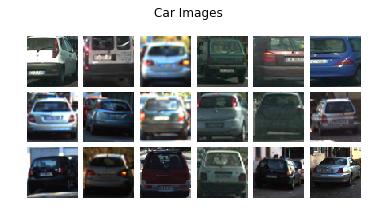

In [2]:
helper.display_random_images(cars, num_of_images=18, main_title='Car Images')

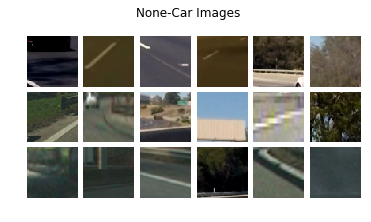

In [3]:
helper.display_random_images(notcars, num_of_images=18, main_title='None-Car Images')

## HOG Classify

In [4]:
from skimage.feature import hog

# return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(file, getattr(cv2, 'COLOR_RGB2' + color_space))
        else:
            feature_image = np.copy(file)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


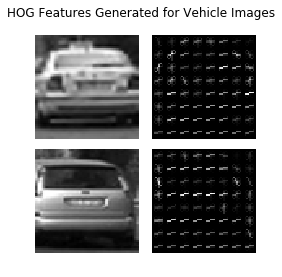

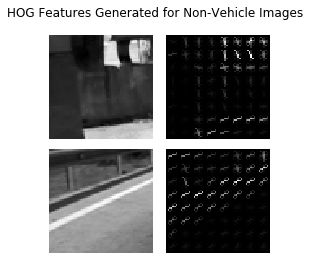

In [5]:
vehicles = []
vehicles_hog_features = []

orient = 9
pix_per_cell = 8
cell_per_block = 2

for i in range(2):
    rnd_idx = np.random.randint(1, car_image_count)
    image = mpimg.imread(cars[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    vehicles.append(hog_image)
    vehicles_hog_features.append(gray)

helper.visualize_hog_features(vehicles, vehicles_hog_features,
                              color_map='gray', suptitle='HOG Features Generated for Vehicle Images')

non_vehicles = []
non_vehicles_hog_features = []

for i in range(2):
    rnd_idx = np.random.randint(1, notcar_image_count)
    image = mpimg.imread(notcars[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    non_vehicles.append(hog_image)
    non_vehicles_hog_features.append(gray)

helper.visualize_hog_features(non_vehicles, non_vehicles_hog_features,
                              color_map='gray', suptitle='HOG Features Generated for Non-Vehicle Images')


In [6]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

In [7]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

t = time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, color_space=colorspace, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   hog_channel=hog_channel)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict, 'labels with SVC')


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


65.0 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
23.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
0.001 Seconds to predict 10 labels with SVC


### Sliding window

In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

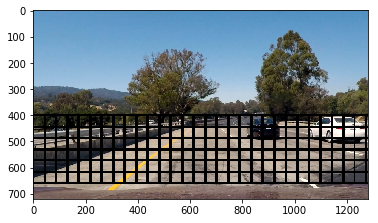

112 boxes


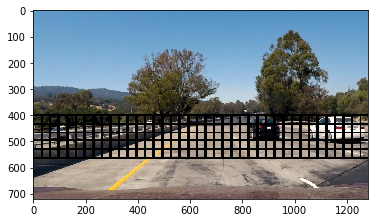

111 boxes


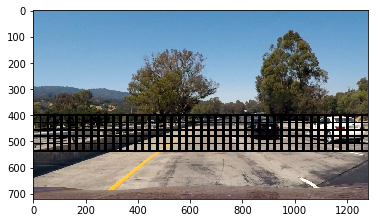

132 boxes


In [9]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

y_start_stops = [ [400,650], [400,550], [400,520] ]
xy_windows = [ (128, 128), (96, 96), (80, 80)]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stops[0] , xy_window=xy_windows[0], xy_overlap=(0.65, 0.65))  
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
print(len(windows), 'boxes')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stops[1] , xy_window=xy_windows[1], xy_overlap=(0.65, 0.65))                    
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
print(len(windows), 'boxes')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stops[2] , xy_window=xy_windows[2], xy_overlap=(0.65, 0.65))                    
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
print(len(windows), 'boxes')

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


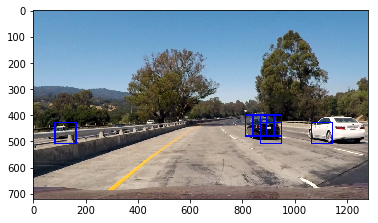

In [11]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)

plt.imshow(window_img)
plt.show()

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

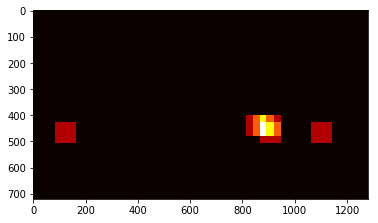

In [13]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
#heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap='hot')

3 cars found


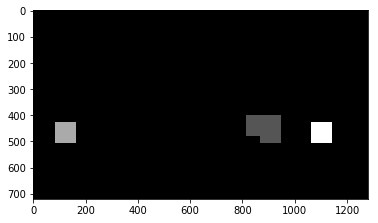

In [14]:
from scipy.ndimage.measurements import label

labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

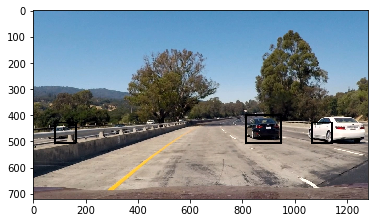

In [15]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

In [20]:
from collections import deque

heat_history = deque(maxlen = 8)

def get_avg_heat_history(heat_history):
    avg_heat_history = np.zeros_like(heat_history[0]).astype(np.float)
    for map_sample in heat_history:
        avg_heat_history += map_sample
    return (avg_heat_history / len(heat_history)).astype(np.int)


def image_pipline(image, debug=False):
    if debug:
        draw_image = np.copy(image)
    output = np.copy(image)
    image = image.astype(np.float32) / 255.0
    
    all_hot_windows = []
    
    if debug:
        t_ = time.time()
    for idx, val in enumerate(xy_windows):                   
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stops[idx] , xy_window=xy_windows[idx],
                               xy_overlap=(0.65, 0.65)) 
        if debug:
            t_1_1 = time.time()
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
        
        all_hot_windows.extend(hot_windows)
        if debug:
            print('{0} found {1} boxes in {2}s'.format(xy_windows[idx], len(hot_windows), round(time.time() - t_1_1, 2)))

    if debug:
        t_2 = time.time()
    
    if debug:
        window_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=3)
        plt.imshow(window_img)
        plt.show()

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,all_hot_windows)
    
    if debug:
        heatmap = np.clip(heat, 0, 255)
        plt.imshow(heatmap, cmap='hot')
        plt.show()
        
    if not debug:
        heat_history.append(heat) #no deletion or pop needed
        heat = get_avg_heat_history(heat_history)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    if debug:
        t_3 = time.time()

    if debug:
        plt.imshow(heatmap, cmap='hot')
        plt.show()
    
    labels = label(heatmap)
    if debug:
        print(labels[1], 'cars found')
        plt.imshow(labels[0], cmap='gray')
        plt.show()
    
    # Draw bounding boxes on a copy of the image
    image_with_boxes = draw_labeled_bboxes(output, labels)
    if debug:
        plt.imshow(image_with_boxes)
        plt.show()
    if debug:
        t_4 = time.time()
    
        print(round(t_2 - t_, 2), 'Seconds to calculate all_hot_windows...')
        print(round(t_3 - t_2, 2), 'Seconds to calculate heatmap...')
        print(round(t_4 - t_3, 2), 'Seconds to calculate image_with_boxes...')
    
    return image_with_boxes

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(128, 128) found 4 boxes in 0.57s
(96, 96) found 4 boxes in 0.53s
(80, 80) found 6 boxes in 0.64s


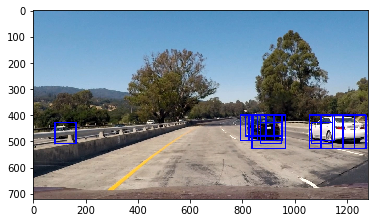

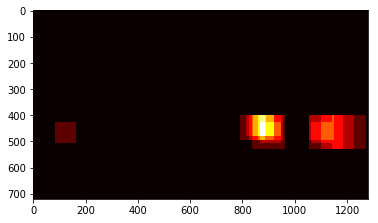

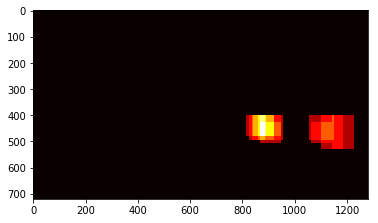

2 cars found


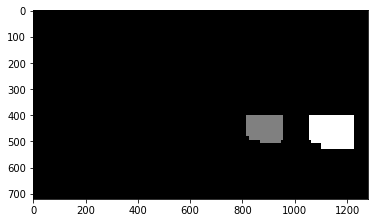

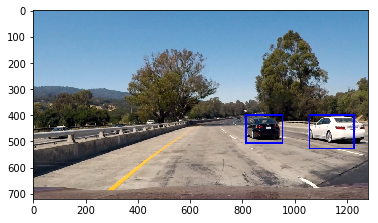

1.74 Seconds to calculate all_hot_windows...
0.43 Seconds to calculate heatmap...
0.6 Seconds to calculate image_with_boxes...


In [17]:
image_with_boxes = image_pipline(mpimg.imread('test_images/test1.jpg'), True)

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


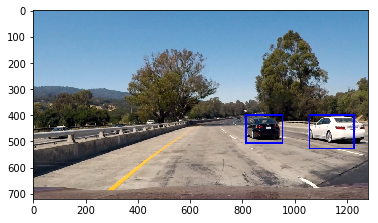

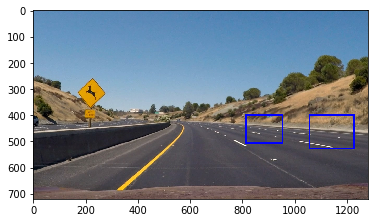

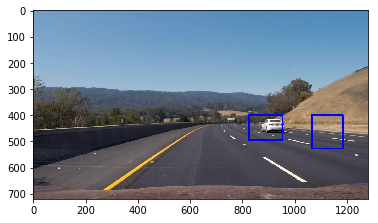

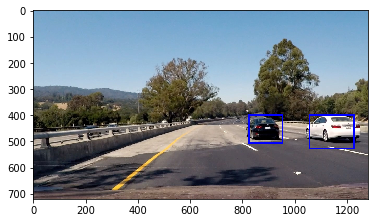

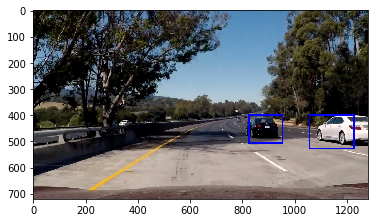

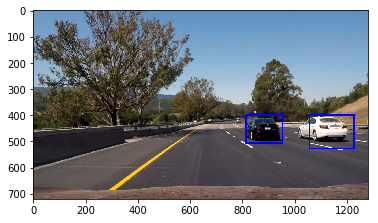

12.12 Seconds to calculate test images...


In [18]:
test_images = glob.glob('test_images/*.jpg', recursive=True)

t = time.time()
for test_image in test_images:
        plt.imshow(image_pipline(mpimg.imread(test_image)))
        plt.show()
        
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to calculate test images...')

In [22]:
from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    
    result = clip.fl_image (image_pipline)
    %time result.write_videofile (output_path)

process_video ('project_video.mp4', 'project_video_result.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing audio in project_video_resultTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:00<00:00, 1867.49it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [34:38<00:01,  1.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 34min 39s
